In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as pth
import sys
import os
os.chdir('/home/561/rmh561/croco/') 

In [2]:
##### Input files #########

iodir = '/g/data/e14/rmh561/croco/data/OASIS_FILES/PAC12_75_cpl/' # Input repository

## ATM ##e
filea = iodir+'wrf_grd.nc' # Atmosphere grid file
filemask= iodir +'wrf_grd.nc' # where to find CPLMASK
extdom = 0  # which external domain should we select in CPLMASK

foldout=iodir # where OASIS_FILES should be

# SST for plotting:
fileo = iodir+'croco_grd.nc'
sstfile = iodir+'sst.nc'
varsst = 'temp_surf'

In [3]:
# Get SST for plotting:
ncf=nc.Dataset(sstfile,'r')
sst=np.squeeze(ncf.variables[varsst][0,1:-1,1:-1])
ncf.close()

ncf=nc.Dataset(fileo,'r')
lono = ncf.variables['lon_rho'][1:-1,1:-1]
lato = ncf.variables['lat_rho'][1:-1,1:-1]
ncf.close()

In [4]:
# check if OASIS_FILES exits
CHECK_FOLDER = os.path.isdir(foldout)
# If doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(foldout)
    print("created folder : ", foldout)
else:
    print(foldout, "folder already exists.")
##########

/g/data/e14/rmh561/croco/data/OASIS_FILES/PAC12_75_cpl/ folder already exists.


In [7]:
#---------------------------------------------------------
# get grids
#---------------------------------------------------------

# wrf grid

ncf=nc.Dataset(filea,'r')
lona = np.squeeze(ncf.variables['XLONG'][:])
lata = np.squeeze(ncf.variables['XLAT'][:])
ncf.close

[jpia,jpja]=np.shape(lona)

# Fix longitude cyclicity:
for ii in range(jpja):
    if (lona[0,ii]<=0):
        lona[:,ii] = lona[:,ii] + 360.

# make mask:
mask = np.zeros(np.shape(lona))

In [6]:
# Simple region:
mask[np.logical_and(np.logical_and(np.logical_and(lona>=200.,lona<=240.),lata>=-10.),lata<=10.)] = 1.

In [ ]:
# Maillard mask:
fileout = 'smooth_mask_Maillard.nc'

x1 = -90.+360.
x2 = -85.+360.
mu = 1.
sig = 10.

# x dependence:
H = np.copy(mask)
H[lona<=x1] = 1.
reg = np.logical_and(lona>=x1,lona<=x2)
H[reg] = 3.*((lona[reg]-x2)/(x1-x2))**2.-2.*((lona[reg]-x2)/(x1-x2))**3.

# y dependence:
I = np.exp(-0.5*((lata-mu)/sig)**2.)

mask = I*H

In [8]:
# Tanh-based mask:
fileout = 'smooth_mask_tanh.nc'

x1 = -90.+360.
x2 = -85.+360.

sig = 1.5
yd = 9.
yi = -9.

# x dependence:
H = np.copy(mask)
H[lona<=x1] = 1.
reg = np.logical_and(lona>=x1,lona<=x2)
H[reg] = 3.*((lona[reg]-x2)/(x1-x2))**2.-2.*((lona[reg]-x2)/(x1-x2))**3.

# y dependence:
I = (np.tanh((lata-yi)/sig)+1.)*(np.tanh((yd-lata)/sig)+1.)/4.

mask = I*H

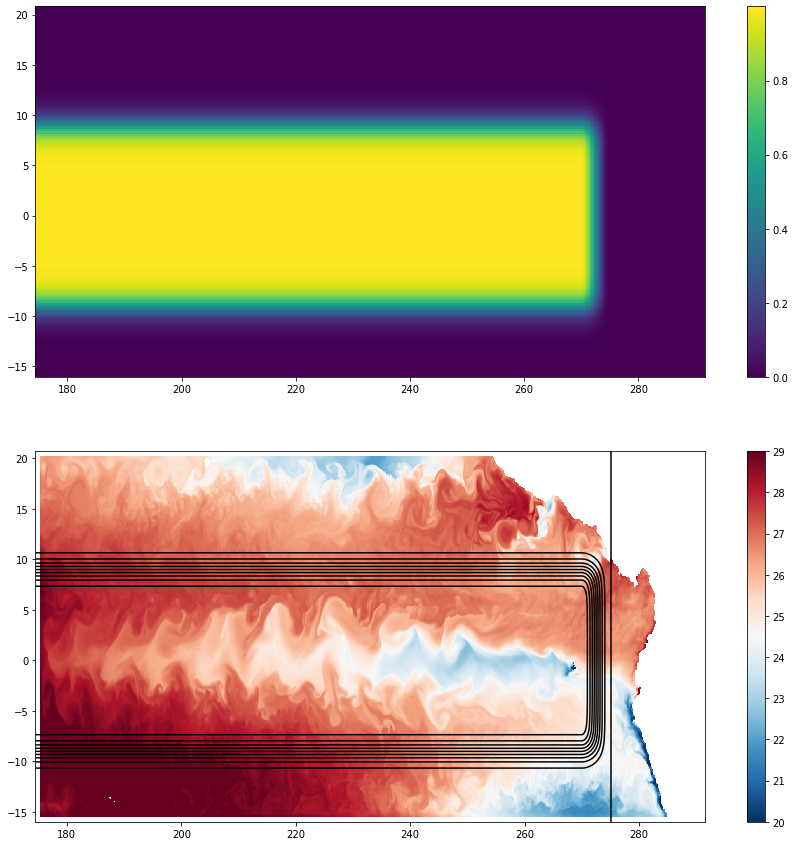

In [9]:
# plot mask:
fig = plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.pcolor(lona,lata,mask)
plt.colorbar()

plt.subplot(2,1,2)
plt.pcolor(lono,lato,sst,vmin=20.,vmax=29.,cmap='RdBu_r')
plt.colorbar()
plt.contour(lona,lata,mask,levels=np.arange(0.,1.,0.1),colors='k')

# write mask for OASIS:

In [ ]:
ncf=nc.Dataset(foldout+'/'+fileout,'w')
ncf.createDimension('y',jpja)
ncf.createDimension('x',jpia)
tmp = ncf.createVariable('SMOOTHMASK','double',('x','y'))
ncf.variables['SMOOTHMASK'][:] = mask
ncf.close()

# write mask for WRF CPLMASK:

In [12]:
# input file:
file_in = '/g/data/e14/rmh561/croco/data/WRF_FILES/PAC12/2014/01/wrfinput_d01_backup_preumasku'
file_out = '/g/data/e14/rmh561/croco/analysis/PAC12_75_cpl/wrf_grd_test.nc'
tmp_dir = '/g/data/e14/rmh561/'

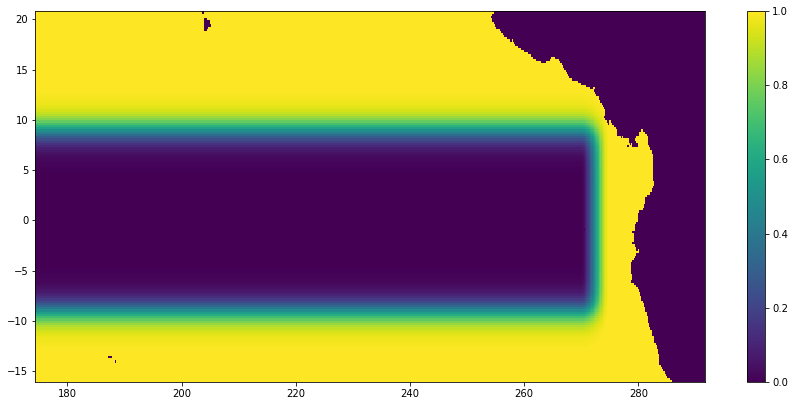

In [13]:
# combine mask and CPLMASK to mask out TIW region:
ncf=nc.Dataset(file_in,'r')
CPLMASK = ncf.variables['CPLMASK'][0,0,:,:]
ncf.close()

mask_comb = np.where(CPLMASK==1,1.-mask,0)

fig = plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.pcolor(lona,lata,mask_comb)
plt.colorbar()

In [16]:
# Copy file, copy variable and combine (using nco - it's quicker):
!cp {file_in} {file_out}
!cp {file_in} {tmp_dir}tmp.nc
!ncrename -h -O -v 'CPLMASK','CPLMASKU' {tmp_dir}tmp.nc
!ncks -A -v CPLMASKU {tmp_dir}tmp.nc {file_out}
!rm {tmp_dir}tmp.nc

In [17]:
# overwrite CPLMASKU in file:
ncf=nc.Dataset(file_out,'a')
ncf.variables['CPLMASKU'][:] = mask_comb
ncf.close()

In [ ]:
# Get/compare smoothed SSTs:

# Original no-masking:
ncf=nc.Dataset(iodir+'sst_interp_smoothgauss_sigx24_sigy01c10.nc','r')
sst_orig=np.squeeze(ncf.variables['temp_surf'][0,:,:])
ncf.close()

# New with masking:
ncf=nc.Dataset(iodir+'sst_interp_smoothgauss_tanhmask_sigx24_cut10.nc','r')
sst_new=np.squeeze(ncf.variables['temp_surf'][:,:])
ncf.close()

fig = plt.figure(figsize=(25,13))

plt.subplot(2,2,1)
plt.pcolor(lono,lato,sst,vmin=20.,vmax=29.,cmap='RdBu_r')
plt.colorbar()
plt.contour(lona,lata,mask,levels=np.arange(0.,1.,0.25),colors='k')
plt.title('Original (CROCO) SST')

plt.subplot(2,2,2)
plt.pcolor(lona,lata,sst_orig,vmin=20.,vmax=29.,cmap='RdBu_r')
plt.colorbar()
plt.title('Unmasked, smoothed SST')

plt.subplot(2,2,3)
plt.pcolor(lona,lata,sst_new,vmin=20.,vmax=29.,cmap='RdBu_r')
plt.colorbar()
plt.title('Masked, smoothed SST')

plt.subplot(2,2,4)
plt.pcolor(lona,lata,sst_new-sst_orig,vmin=-2.,vmax=2.,cmap='RdBu_r')
plt.colorbar()
plt.title('Difference masked-unmasked')

In [ ]:
# Quick test of smoothing width:

sigx = 24.
dx = 1./4.

nn = int(3*2*sigx+1)
xx = np.arange(0,nn)
dd = np.sqrt( ((xx-int(nn/2))**2)/sigx**2 )
ww = 1./(np.sqrt(np.pi)*sigx) *np.exp( -dd**2 )

In [ ]:
plt.plot(xx*dx,ww)

In [ ]:
(24.*dx)*2.4